In [375]:
# Optional: quiet JAX TPU noise globally (if you import GEV in this notebook elsewhere)
import os; os.environ["JAX_PLATFORMS"] = "cpu"

from pathlib import Path
import sys, numpy as np, matplotlib.pyplot as plt

# import generator module from same folder
from generator import generate_gev_dataset_blobs, plot_random_spatial_slice, plot_random_time_series,generate_gev_dataset_linear

current_dir = Path.cwd()
project_root = current_dir.parent.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
#Refactored GEV API
import Refactor.gevPackage as gev
from EVT_Classes.selector import select_spatial_neighborhood

#Old GEV API
#from EVT_Classes.GEV import GEV

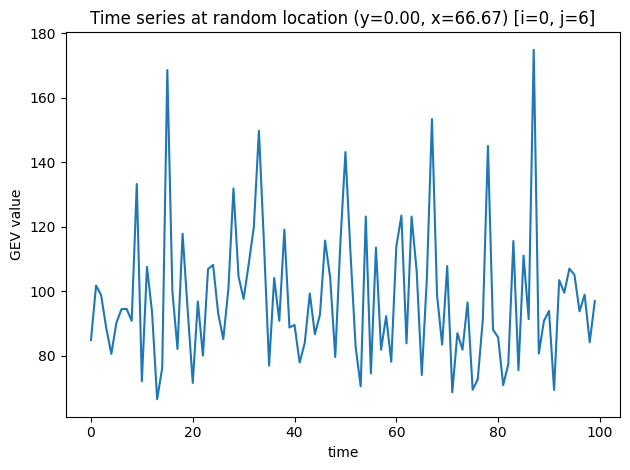

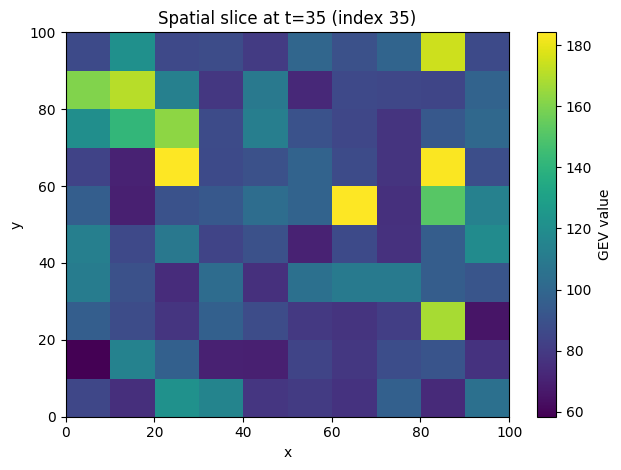

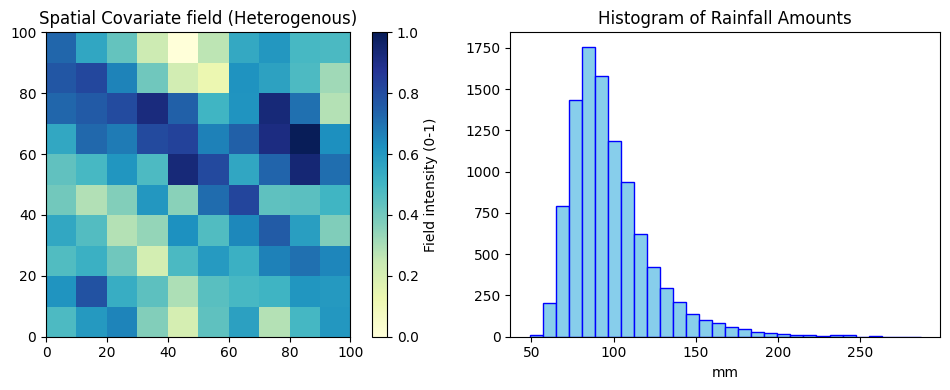

In [386]:
gen_kwargs = dict(n_lat=10, n_lon=10, n_time=100,
                  beta_mu0=70, beta_mu_t=0, beta_ls0=np.log(11.0),beta_ls_s=np.log(2),beta_mu_s=30,xi_noise=False,xi_noise_amp=0.05,seed=2025)

data, meta = generate_gev_dataset_blobs(**gen_kwargs,)
plot_random_time_series(data, meta)
plot_random_spatial_slice(data, meta)

# Plot the Field (Should range 0 to 1)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
# Note: using a colormap like 'Blues' or 'YlGnBu' feels more like rain
im = plt.imshow(meta["s_field"], origin="lower", cmap="YlGnBu", extent=[0, 100, 0, 100])
plt.colorbar(im, label="Field intensity (0-1)")
plt.title("Spatial Covariate field (Heterogenous)")

# Plot the resulting Data (Should be > 0)
plt.subplot(1, 2, 2)
plt.hist(data.flatten(), bins=30, color='skyblue', edgecolor='blue')
plt.title("Histogram of Rainfall Amounts")
plt.xlabel("mm")

plt.tight_layout()
plt.show()

In [387]:
# Cell A (replacement) - data + neighborhoods + reusable static distance tensors
from pathlib import Path
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# make EVT_Classes importable from SIM/
current_dir = Path.cwd().resolve()
evt_classes_dir = current_dir.parent
if str(evt_classes_dir) not in sys.path:
    sys.path.insert(0, str(evt_classes_dir))

from selector import select_spatial_neighborhood

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

# data must already exist: shape (T, H, W)
T, H, W = data.shape
S = H * W

Y_np = data.reshape(T, S).astype(np.float64)
Y = torch.from_numpy(Y_np).to(device)

selector_args = {
    "mode": "circle",       # "square" or "circle"
    "radius": None,         # None => full-grid fallback
    "max_points": 100,
    "include_center": True,
}

def build_neighbor_tables(n_lat, n_lon, selector_args, device):
    s_total = n_lat * n_lon
    idx_list, d2_list = [], []

    for s in range(s_total):
        i0, j0 = divmod(s, n_lon)
        sel = select_spatial_neighborhood(
            n_lat=n_lat,
            n_lon=n_lon,
            i=i0,
            j=j0,
            mode=selector_args["mode"],
            radius=selector_args["radius"],
            max_points=selector_args["max_points"],
            include_center=selector_args["include_center"],
        )

        flat = sel.flat_idx.astype(np.int64)
        if flat.size == 0:
            flat = np.array([s], dtype=np.int64)

        ii = flat // n_lon
        jj = flat % n_lon
        d2 = ((ii - i0) ** 2 + (jj - j0) ** 2).astype(np.float64)

        idx_list.append(flat)
        d2_list.append(d2)

    k_max = max(len(x) for x in idx_list)

    nbr_idx = np.zeros((s_total, k_max), dtype=np.int64)
    nbr_d2 = np.zeros((s_total, k_max), dtype=np.float64)
    nbr_mask = np.zeros((s_total, k_max), dtype=bool)

    for s, (fi, fd2) in enumerate(zip(idx_list, d2_list)):
        k = len(fi)
        nbr_idx[s, :k] = fi
        nbr_d2[s, :k] = fd2
        nbr_mask[s, :k] = True
        if k < k_max:
            nbr_idx[s, k:] = fi[0]
            nbr_d2[s, k:] = fd2[0]

    return (
        torch.tensor(nbr_idx, dtype=torch.long, device=device),      # (S, K)
        torch.tensor(nbr_d2, dtype=torch.float64, device=device),    # (S, K)
        torch.tensor(nbr_mask, dtype=torch.bool, device=device),     # (S, K)
    )

nbr_idx, nbr_d2, nbr_mask = build_neighbor_tables(H, W, selector_args, device)
print("Neighbor table shapes:", nbr_idx.shape, nbr_d2.shape, nbr_mask.shape)

# Reusable static distance tensor candidate: normalized spatial distance
d_space = torch.sqrt(nbr_d2.clamp_min(0.0))
d_valid = d_space[nbr_mask]
d_pos = d_valid[d_valid > 0]
space_scale = float(torch.median(d_pos).item()) if d_pos.numel() > 0 else 1.0
space_scale = max(space_scale, 1e-8)

d_space_norm_train = (d_space / space_scale) * nbr_mask  # (S,K)
print("d_space_norm_train shape:", tuple(d_space_norm_train.shape), "| space_scale =", space_scale)


Neighbor table shapes: torch.Size([100, 100]) torch.Size([100, 100]) torch.Size([100, 100])
d_space_norm_train shape: (100, 100) | space_scale = 5.0990195135927845


In [388]:
# Cell B (replacement) - feature registry + pure energy kernel model
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def inv_softplus_np(x):
    x = np.asarray(x, dtype=np.float64)
    x = np.maximum(x, 1e-12)
    return np.log(np.expm1(x) + 1e-12)

def robust_pair_scale_1d(v, num_pairs=200_000, seed=2025):
    v = np.asarray(v, dtype=np.float64).reshape(-1)
    n = v.size
    if n < 2:
        return 1.0
    m = min(num_pairs, max(1, n * (n - 1)))
    rng = np.random.default_rng(seed)
    i = rng.integers(0, n, size=m)
    j = rng.integers(0, n - 1, size=m)
    j = j + (j >= i)
    d = np.abs(v[i] - v[j])
    return float(np.median(d)) + 1e-8


class KernelFeatureBank:
    """
    Central registry for kernel inputs.
    Add/remove features here; training + adapter both use the same registry.
    """

    def __init__(self):
        self.static_specs = []
        self.dynamic_specs = []

    def add_static(self, name, train_tensor_sk, infer_fn):
        if not torch.is_tensor(train_tensor_sk):
            train_tensor_sk = torch.tensor(train_tensor_sk, dtype=torch.float64)
        else:
            train_tensor_sk = train_tensor_sk.to(dtype=torch.float64)

        self.static_specs.append({
            "name": str(name),
            "train_tensor": train_tensor_sk,  # (S,K)
            "infer_fn": infer_fn,             # fn(i,j,coords,flat,target_flat,params_np)->(K,)
        })

    def add_dynamic_sqdiff(self, name, param_key, scale2):
        self.dynamic_specs.append({
            "name": str(name),
            "param_key": str(param_key),
            "scale2": float(max(scale2, 1e-12)),
        })

    @property
    def in_dim(self):
        return len(self.static_specs) + len(self.dynamic_specs)

    @property
    def feature_names(self):
        return [d["name"] for d in self.static_specs] + [d["name"] for d in self.dynamic_specs]

    def build_batch(self, q_idx, idx, params_t):
        if self.in_dim == 0:
            raise ValueError("No kernel features configured in KernelFeatureBank.")

        feat_list = []

        for spec in self.static_specs:
            t = spec["train_tensor"]
            if t.device != q_idx.device:
                t = t.to(q_idx.device)
            feat_list.append(t[q_idx])  # (B,K)

        for spec in self.dynamic_specs:
            p = params_t[spec["param_key"]]            # (S,)
            q = p[q_idx].unsqueeze(1)                  # (B,1)
            n = p[idx]                                 # (B,K)
            feat = ((n - q) ** 2) / spec["scale2"]    # (B,K)
            feat_list.append(feat)

        return torch.stack(feat_list, dim=-1)         # (B,K,F)

    def build_infer(self, i, j, coords, flat, target_flat, params_np):
        if self.in_dim == 0:
            raise ValueError("No kernel features configured in KernelFeatureBank.")

        feat_list = []

        for spec in self.static_specs:
            v = np.asarray(spec["infer_fn"](i, j, coords, flat, target_flat, params_np), dtype=np.float64)
            feat_list.append(v)

        for spec in self.dynamic_specs:
            p = np.asarray(params_np[spec["param_key"]], dtype=np.float64)  # (S,)
            v = ((p[flat] - p[target_flat]) ** 2) / spec["scale2"]
            feat_list.append(v)

        return np.stack(feat_list, axis=-1)  # (K,F)


class EnergyKernelJointGEV(nn.Module):
    """
    Pure energy kernel:
      logits = -E
      w = softmax(logits)
      E(x) = ||x||_1 * softplus(MLP(x))
    """

    def __init__(
        self,
        y_ts_np,
        kernel_in_dim,
        energy_hidden=(64, 32),
        xi_bound=0.35,
        sigma_min=1e-4,
        xi_init=0.1,
    ):
        super().__init__()

        mu0 = np.mean(y_ts_np, axis=0)
        sig0 = np.std(y_ts_np, axis=0, ddof=1)
        sig0 = np.clip(sig0, 1e-3, None)

        self.mu = nn.Parameter(torch.tensor(mu0, dtype=torch.float64))
        self.raw_sigma = nn.Parameter(torch.tensor(inv_softplus_np(sig0), dtype=torch.float64))

        xi0 = float(np.clip(xi_init, -0.95 * xi_bound, 0.95 * xi_bound))
        raw_xi0 = np.arctanh(xi0 / xi_bound)
        self.raw_xi = nn.Parameter(torch.full_like(self.mu, raw_xi0))

        self.kernel_in_dim = int(kernel_in_dim)
        dims = [self.kernel_in_dim, *[int(h) for h in energy_hidden], 1]
        layers = []
        for a, b in zip(dims[:-2], dims[1:-1]):
            layers += [nn.Linear(a, b), nn.ReLU()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.energy_net = nn.Sequential(*layers)

        self.xi_bound = float(xi_bound)
        self.sigma_min = float(sigma_min)

    def constrained(self):
        sigma = F.softplus(self.raw_sigma) + self.sigma_min
        xi = self.xi_bound * torch.tanh(self.raw_xi)
        return self.mu, sigma, xi

    def kernel_energy_from_input(self, x_bkf):
        B, K, Fdim = x_bkf.shape
        e_raw = self.energy_net(x_bkf.reshape(B * K, Fdim)).reshape(B, K)
        x_norm = x_bkf.clamp_min(0.0).sum(dim=-1)
        return x_norm * F.softplus(e_raw)

    def kernel_logits(self, x_bkf):
        energy = self.kernel_energy_from_input(x_bkf)
        logits = -energy
        return logits, energy


def joint_batch_nll_energy_kernel(
    model,
    Y_ts,          # (T,S)
    q_idx,         # (B,)
    nbr_idx,       # (S,K)
    nbr_mask,      # (S,K) bool
    feature_bank,  # KernelFeatureBank
    tau=1.0,
    xi_eps=1e-6,
    penalty=1e6,
):
    mu_all, sigma_all, xi_all = model.constrained()

    idx = nbr_idx[q_idx]       # (B,K)
    mask = nbr_mask[q_idx]     # (B,K)

    params_t = {
        "mu": mu_all,
        "sigma": sigma_all,
        "xi": xi_all,
        "logsigma": torch.log(sigma_all.clamp_min(1e-12)),
    }

    x_bkf = feature_bank.build_batch(q_idx=q_idx, idx=idx, params_t=params_t)  # (B,K,F)

    logits, energy = model.kernel_logits(x_bkf)
    logits = logits.masked_fill(~mask, -1e9)

    w = torch.softmax(logits / tau, dim=1)
    w = w * mask
    w = w / w.sum(dim=1, keepdim=True).clamp_min(1e-12)

    # Likelihood under target-site theta(q)
    y_tbk = Y_ts[:, idx]   # (T,B,K)
    sigma_q = sigma_all[q_idx]
    xi_q = xi_all[q_idx]
    mu_q = mu_all[q_idx].unsqueeze(1)

    mu3 = mu_q[None, :, :]               # (1,B,1)
    sg3 = sigma_q[None, :, None]         # (1,B,1)
    xi3 = xi_q[None, :, None]            # (1,B,1)

    z = (y_tbk - mu3) / sg3
    nll_g = torch.log(sg3) + z + torch.exp(torch.clamp(-z, max=40.0))

    xi_safe = xi_q + xi_eps * torch.tanh(xi_q / xi_eps)
    xi_safe3 = xi_safe[None, :, None]

    t = 1.0 + xi_safe3 * z
    valid = t > 0.0
    log_t = torch.log(torch.clamp(t, min=1e-12))
    pow_term = torch.exp(torch.clamp(-log_t / xi_safe3, min=-40.0, max=40.0))
    nll_gev = torch.log(sg3) + (1.0 + 1.0 / xi_safe3) * log_t + pow_term
    nll_gev = torch.where(valid, nll_gev, torch.full_like(nll_gev, penalty))

    row_nll = (w[None, :, :] * nll_gev).sum(dim=2)  # (T,B)
    nll_mean = row_nll.mean()

    ess = 1.0 / (w.pow(2).sum(dim=1) + 1e-12)
    return nll_mean, ess, w, logits, energy


Kernel features: ['x_space', 'x_mu']
Kernel input dimension: 2
ep=001 train_nll=4.60028 train_loss=4.63691 val_nll=4.60158 ESS=61.00 |xi|mean=2.0069e-02 logit(mean,std)=(-2.087,1.763) RMSE=nan Cov=nan% Width=nan
ep=002 train_nll=4.59588 train_loss=4.63164 val_nll=4.59876 ESS=58.00 |xi|mean=2.0120e-02 logit(mean,std)=(-2.367,2.430) RMSE=nan Cov=nan% Width=nan
ep=003 train_nll=4.59331 train_loss=4.62824 val_nll=4.59675 ESS=55.94 |xi|mean=2.0152e-02 logit(mean,std)=(-2.651,3.159) RMSE=nan Cov=nan% Width=nan
ep=004 train_nll=4.59144 train_loss=4.62558 val_nll=4.59504 ESS=54.26 |xi|mean=2.0171e-02 logit(mean,std)=(-3.002,4.135) RMSE=nan Cov=nan% Width=nan
ep=005 train_nll=4.58985 train_loss=4.62323 val_nll=4.59356 ESS=52.73 |xi|mean=2.0178e-02 logit(mean,std)=(-3.404,5.302) RMSE=nan Cov=nan% Width=nan
ep=006 train_nll=4.58845 train_loss=4.62109 val_nll=4.59223 ESS=51.31 |xi|mean=2.0177e-02 logit(mean,std)=(-3.836,6.544) RMSE=nan Cov=nan% Width=nan
ep=007 train_nll=4.58718 train_loss=4.61912

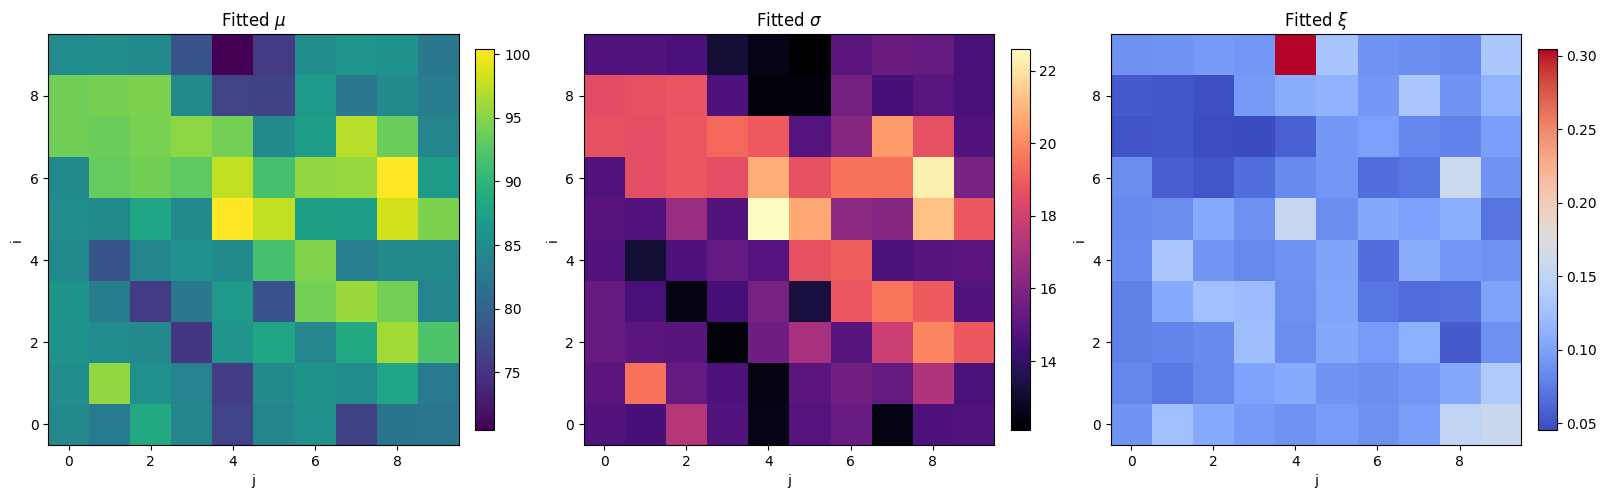

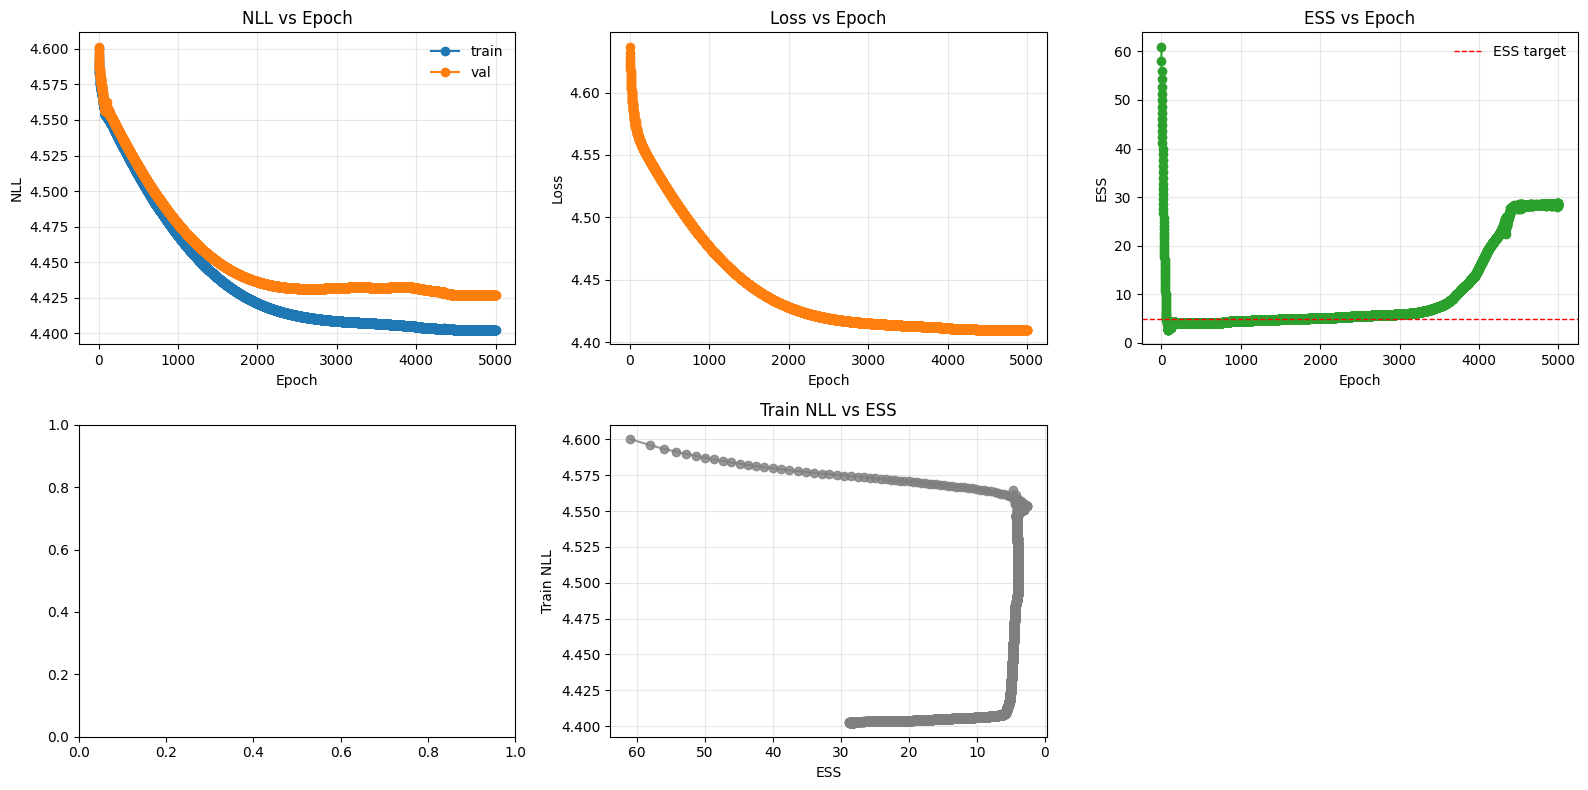

In [399]:
# Cell C (replacement) - training loop + feature registry config
torch.set_default_dtype(torch.float64)

# Robust scales for possible dynamic features
mu_init_np = np.mean(Y_np, axis=0)
mu_scale = robust_pair_scale_1d(mu_init_np, num_pairs=200_000, seed=2025)
mu_scale2 = max(mu_scale ** 2, 1e-8)

sig_init_np = np.std(Y_np, axis=0, ddof=1)
sig_init_np = np.clip(sig_init_np, 1e-6, None)
logsig_init_np = np.log(sig_init_np)
logsig_scale = robust_pair_scale_1d(logsig_init_np, num_pairs=200_000, seed=2025)
logsig_scale2 = max(logsig_scale ** 2, 1e-8)

# ---------- ONLY EDIT THIS BLOCK TO ADD/REMOVE FEATURES ----------
feature_bank = KernelFeatureBank()

def infer_x_space(i, j, coords, flat, target_flat, params_np):
    return np.sqrt((coords[:, 0] - i) ** 2 + (coords[:, 1] - j) ** 2) / space_scale

# static
feature_bank.add_static(
    name="x_space",
    train_tensor_sk=d_space_norm_train,
    infer_fn=infer_x_space,
)

# dynamic
feature_bank.add_dynamic_sqdiff(name="x_mu", param_key="mu", scale2=mu_scale2)

# Uncomment to add dynamic log-sigma distance
#feature_bank.add_dynamic_sqdiff(name="x_logsigma", param_key="logsigma", scale2=logsig_scale2)

# Example for xi later (define xi_scale2 first):
# xi_scale2 = ...
# feature_bank.add_dynamic_sqdiff(name="x_xi", param_key="xi", scale2=xi_scale2)
# -----------------------------------------------------------------

if feature_bank.in_dim == 0:
    raise ValueError("No features configured.")

print("Kernel features:", feature_bank.feature_names)
print("Kernel input dimension:", feature_bank.in_dim)

# Time split
rng = np.random.default_rng(2025)
all_t = np.arange(T)
rng.shuffle(all_t)
n_train_t = max(2, int(0.8 * T))
tr_t = torch.tensor(np.sort(all_t[:n_train_t]), dtype=torch.long, device=device)
va_t = torch.tensor(np.sort(all_t[n_train_t:]), dtype=torch.long, device=device)

Y_tr = Y.index_select(0, tr_t)
Y_va = Y.index_select(0, va_t) if va_t.numel() > 0 else Y_tr

model = EnergyKernelJointGEV(
    y_ts_np=Y_np,
    kernel_in_dim=feature_bank.in_dim,
    energy_hidden=(64, 32),
    xi_bound=0.35,
    sigma_min=1e-4,
    xi_init=0.02,
).to(device).double()

# Optional: flatter initial energies => higher initial ESS

opt = torch.optim.Adam(model.parameters(), lr=5e-3)

epochs = 5000
batch_sites = min(100, S)
val_sites = min(256, S)
patience = 100000

lambda_xi = 1e-6
lambda_kernel = 1e-1
lambda_ess = 1e-3
ess_target = 5
ess_target_t = torch.tensor(float(ess_target), dtype=torch.float64, device=device)

hist = {
    "train_nll": [],
    "train_loss": [],
    "val_nll": [],
    "mean_ess": [],
    "logit_mean": [],
    "logit_std": [],
}

DO_SIM_VALIDATION = False
SIM_EVERY = 60
N_VAL_RUNS = 10
TEST_I, TEST_J = 4, 4
TEST_T_IDX = 30
TEST_RETURN_T = 100

TRACK_SOURCE = "return_levels"
TRACK_KEY = str(TEST_RETURN_T) if TRACK_SOURCE == "return_levels" else "u0"

hist.update({"rmse": [], "cov": [], "width": []})

def _extract_sim_metrics(sim_out, source, key):
    m = sim_out[source][key]
    return float(m["rmse"]), float(m["coverage_prob"]), float(m["mean_ci_width"])

best_val = float("inf")
best_state = None
wait = 0

for ep in range(1, epochs + 1):
    model.train()
    perm = torch.randperm(S, device=device)

    ep_nll = 0.0
    ep_loss = 0.0
    ep_ess = 0.0
    ep_logit_mean = 0.0
    ep_logit_std = 0.0
    nb = 0

    tau_ep = 1  # can schedule this if needed

    for s0 in range(0, S, batch_sites):
        q_idx = perm[s0:s0 + batch_sites]
        if q_idx.numel() == 0:
            continue

        nll, ess, _, logits, _ = joint_batch_nll_energy_kernel(
            model=model,
            Y_ts=Y_tr,
            q_idx=q_idx,
            nbr_idx=nbr_idx,
            nbr_mask=nbr_mask,
            feature_bank=feature_bank,
            tau=tau_ep,
        )

        _, _, xi_all = model.constrained()
        reg_xi = lambda_xi * torch.mean((xi_all / model.xi_bound) ** 2)
        reg_kernel = lambda_kernel * sum(torch.mean(p * p) for p in model.energy_net.parameters())
        reg_ess = lambda_ess * torch.mean(torch.relu(ess_target_t - ess) ** 2)

        loss = nll + reg_kernel + reg_ess #reg_xi + reg_kernel + reg_ess

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        ep_nll += float(nll.detach().cpu())
        ep_loss += float(loss.detach().cpu())
        ep_ess += float(ess.mean().detach().cpu())
        ep_logit_mean += float(logits.mean().detach().cpu())
        ep_logit_std += float(logits.std(unbiased=False).detach().cpu())
        nb += 1

    train_nll = ep_nll / max(1, nb)
    train_loss = ep_loss / max(1, nb)
    mean_ess = ep_ess / max(1, nb)
    mean_logit = ep_logit_mean / max(1, nb)
    std_logit = ep_logit_std / max(1, nb)

    model.eval()
    with torch.no_grad():
        qv = torch.randperm(S, device=device)[:val_sites]
        val_nll_t, _, _, logits_val, _ = joint_batch_nll_energy_kernel(
            model=model,
            Y_ts=Y_va,
            q_idx=qv,
            nbr_idx=nbr_idx,
            nbr_mask=nbr_mask,
            feature_bank=feature_bank,
            tau=tau_ep,
        )
        val_nll = float(val_nll_t.detach().cpu())
        val_logit_mean = float(logits_val.mean().detach().cpu())
        val_logit_std = float(logits_val.std(unbiased=False).detach().cpu())

    rmse_val = cov_val = width_val = float("nan")

    if DO_SIM_VALIDATION and (ep == 1 or  ep%50==0 or SIM_EVERY == 0):
        if "FlexibleKernelWeightAdapter" not in globals():
            raise RuntimeError("Run Cell D first so FlexibleKernelWeightAdapter is defined.")

        epoch_adapter = FlexibleKernelWeightAdapter(
            trained_model=model,
            feature_bank=feature_bank,
            selector_args=selector_args,
            device=device,
        )

        sim_out = compute_combined_sim(
            generate_fn=generate_gev_dataset_linear,
            gen_kwargs=gen_kwargs,
            i=TEST_I, j=TEST_J,
            n_runs=N_VAL_RUNS,
            return_periods=[TEST_RETURN_T],
            t_idx=TEST_T_IDX,
            n_jobs_runs=-1,
            backend="threading",
            verbose=False,
            fit_mode="full",
            weights=epoch_adapter,
        )
        rmse_val, cov_val, width_val = _extract_sim_metrics(sim_out, TRACK_SOURCE, TRACK_KEY)
    elif hist["rmse"]:
        rmse_val, cov_val, width_val = hist["rmse"][-1], hist["cov"][-1], hist["width"][-1]

    hist["rmse"].append(rmse_val)
    hist["cov"].append(cov_val)
    hist["width"].append(width_val)

    hist["train_nll"].append(train_nll)
    hist["train_loss"].append(train_loss)
    hist["val_nll"].append(val_nll)
    hist["mean_ess"].append(mean_ess)
    hist["logit_mean"].append(mean_logit)
    hist["logit_std"].append(std_logit)

    _, _, xi_all_chk = model.constrained()
    xi_abs_mean = xi_all_chk.detach().abs().mean().item()
    print(
        f"ep={ep:03d} train_nll={train_nll:.5f} train_loss={train_loss:.5f} "
        f"val_nll={val_nll:.5f} ESS={mean_ess:.2f} |xi|mean={xi_abs_mean:.4e} "
        f"logit(mean,std)=({val_logit_mean:.3f},{val_logit_std:.3f}) "
        f"RMSE={rmse_val:.3f} Cov={cov_val:.1%} Width={width_val:.3f}"
    )

    if val_nll < best_val:
        best_val = val_nll
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stop at ep={ep}, best val NLL={best_val:.6f}")
            break

if best_state is not None:
    model.load_state_dict(best_state)

print("Best val NLL:", best_val)

# =========================
# Plots (Cell C)
# =========================
import numpy as np
import matplotlib.pyplot as plt

# ---- fitted theta maps ----
with torch.no_grad():
    mu_hat_t, sigma_hat_t, xi_hat_t = model.constrained()

mu_hat = mu_hat_t.detach().cpu().numpy().astype(np.float64).reshape(H, W)
sigma_hat = sigma_hat_t.detach().cpu().numpy().astype(np.float64).reshape(H, W)
xi_hat = xi_hat_t.detach().cpu().numpy().astype(np.float64).reshape(H, W)

print("Kernel features:", feature_bank.feature_names)
print("Kernel input dimension:", model.kernel_in_dim)
print("mu    : min={:.4f}, mean={:.4f}, max={:.4f}".format(mu_hat.min(), mu_hat.mean(), mu_hat.max()))
print("sigma : min={:.4f}, mean={:.4f}, max={:.4f}".format(sigma_hat.min(), sigma_hat.mean(), sigma_hat.max()))
print("xi    : min={:.4f}, mean={:.4f}, max={:.4f}".format(xi_hat.min(), xi_hat.mean(), xi_hat.max()))

fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), constrained_layout=True)

im0 = axes[0].imshow(mu_hat, origin="lower", cmap="viridis")
axes[0].set_title("Fitted $\\mu$")
axes[0].set_xlabel("j"); axes[0].set_ylabel("i")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(sigma_hat, origin="lower", cmap="magma")
axes[1].set_title("Fitted $\\sigma$")
axes[1].set_xlabel("j"); axes[1].set_ylabel("i")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(xi_hat, origin="lower", cmap="coolwarm")
axes[2].set_title("Fitted $\\xi$")
axes[2].set_xlabel("j"); axes[2].set_ylabel("i")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.show()

# ---- training diagnostics ----
ep_arr = np.arange(1, len(hist["train_nll"]) + 1)

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

axes[0, 0].plot(ep_arr, hist["train_nll"], marker="o", label="train")
axes[0, 0].plot(ep_arr, hist["val_nll"], marker="o", label="val")
axes[0, 0].set_title("NLL vs Epoch")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("NLL")
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend(frameon=False)

axes[0, 1].plot(ep_arr, hist["train_loss"], marker="o", color="tab:orange")
axes[0, 1].set_title("Loss vs Epoch")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].grid(alpha=0.3)

axes[0, 2].plot(ep_arr, hist["mean_ess"], marker="o", color="tab:green")
axes[0, 2].axhline(ess_target, color="r", ls="--", linewidth=1.0, label="ESS target")
axes[0, 2].set_title("ESS vs Epoch")
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("ESS")
axes[0, 2].grid(alpha=0.3)
axes[0, 2].legend(frameon=False)

#axes[1, 0].plot(ep_arr, hist["logit_mean"], marker="o", color="tab:purple", label="logit mean")
#axes[1, 0].plot(ep_arr, hist["logit_std"], marker="o", color="tab:brown", label="logit std")
#axes[1, 0].set_title("Kernel Logits")
#axes[1, 0].set_xlabel("Epoch")
#axes[1, 0].set_ylabel("value")
#axes[1, 0].grid(alpha=0.3)
#axes[1, 0].legend(frameon=False)

axes[1, 1].plot(hist["mean_ess"], hist["train_nll"], marker="o", alpha=0.8, color="tab:gray")
axes[1, 1].set_title("Train NLL vs ESS")
axes[1, 1].set_xlabel("ESS")
axes[1, 1].set_ylabel("Train NLL")
axes[1, 1].invert_xaxis()
axes[1, 1].grid(alpha=0.3)

axes[1, 2].axis("off")
plt.tight_layout()
plt.show()

# ---- sim metrics (if enabled) ----
rmse_arr = np.array(hist.get("rmse", []), dtype=float)
if rmse_arr.size > 0 and np.isfinite(rmse_arr).any():
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    plt.subplots_adjust(wspace=0.3)

    axes[0].plot(ep_arr, hist["rmse"], marker="o")
    axes[0].set_title(f"RMSE ({TRACK_SOURCE}:{TRACK_KEY})")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("RMSE")
    axes[0].grid(alpha=0.3)

    axes[1].plot(ep_arr, hist["cov"], marker="o", color="tab:green", label="Coverage")
    axes[1].axhline(0.95, color="r", ls="--", linewidth=1.0, label="Target 95%")
    axes[1].set_title("Coverage Probability")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Coverage")
    axes[1].set_ylim(0, 1.05)
    axes[1].grid(alpha=0.3)
    axes[1].legend(frameon=False)

    axes[2].plot(ep_arr, hist["width"], marker="o", color="tab:olive")
    axes[2].set_title("Confidence Interval Width")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Width")
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()



Adapter ready. Features: ['x_space', 'x_mu']


C:\Users\robert\AppData\Local\Temp\ipykernel_33928\3435706013.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(frameon=False)


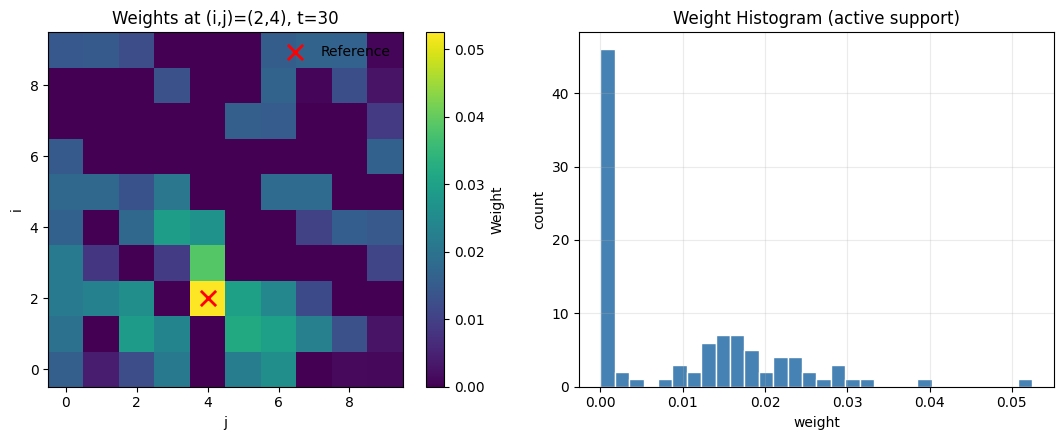

K_active=100, ESS=44.68, min=9.368e-98, max=5.251e-02


In [400]:
# Cell D (replacement) - adapter using the same KernelFeatureBank
import numpy as np
import torch
import matplotlib.pyplot as plt

class FlexibleKernelWeightAdapter:
    def __init__(self, trained_model, feature_bank, selector_args=None, device="cpu"):
        self.model = trained_model
        self.model.eval()
        self.feature_bank = feature_bank
        self.device = device

        self.cfg = {"mode": "full", "radius": None, "max_points": None, "include_center": True}
        if selector_args is not None:
            self.cfg.update(selector_args)

        with torch.no_grad():
            mu_all, sigma_all, xi_all = self.model.constrained()

        mu_np = mu_all.detach().cpu().numpy().astype(np.float64)
        sigma_np = sigma_all.detach().cpu().numpy().astype(np.float64)
        xi_np = xi_all.detach().cpu().numpy().astype(np.float64)

        self.params_np = {
            "mu": mu_np,
            "sigma": sigma_np,
            "xi": xi_np,
            "logsigma": np.log(np.clip(sigma_np, 1e-12, None)),
        }

    def __call__(self, teacher, i, j, t_idx, data_shape, **kwargs):
        n_time, n_lat, n_lon = data_shape
        target_flat = int(i * n_lon + j)

        mode = str(self.cfg["mode"]).lower()
        if mode == "full":
            ii, jj = np.meshgrid(np.arange(n_lat), np.arange(n_lon), indexing="ij")
            coords = np.column_stack([ii.ravel(), jj.ravel()]).astype(np.int64)
        else:
            sel = select_spatial_neighborhood(
                n_lat=n_lat, n_lon=n_lon, i=i, j=j,
                mode=self.cfg["mode"], radius=self.cfg["radius"],
                max_points=self.cfg["max_points"], include_center=self.cfg["include_center"],
            )
            coords = sel.coords.astype(np.int64)
            if coords.shape[0] == 0:
                coords = np.array([[i, j]], dtype=np.int64)

        flat = coords[:, 0] * n_lon + coords[:, 1]

        X_np = self.feature_bank.build_infer(
            i=i, j=j, coords=coords, flat=flat, target_flat=target_flat, params_np=self.params_np
        )  # (K,F)

        with torch.inference_mode():
            x_t = torch.from_numpy(X_np).to(self.device, dtype=torch.float64).unsqueeze(0)  # (1,K,F)
            energy = self.model.kernel_energy_from_input(x_t).squeeze(0)                     # (K,)
            logits = -energy

            if teacher is not None and "ok_mask" in teacher:
                ok = np.asarray(teacher["ok_mask"], dtype=bool)
                if ok.ndim == 3:
                    t_use = int(np.clip(t_idx, 0, n_time - 1))
                    ok = ok[t_use]
                ok_flat_local = torch.as_tensor(ok.reshape(-1)[flat], device=self.device, dtype=torch.bool)
                logits = logits.masked_fill(~ok_flat_local, -1e9)

            probs = torch.softmax(logits, dim=0).detach().cpu().numpy().astype(np.float64)

        if (not np.isfinite(probs).all()) or (probs.sum() <= 0):
            probs = np.zeros(len(flat), dtype=np.float64)
            probs[0] = 1.0

        w_map = np.zeros((n_lat, n_lon), dtype=np.float64)
        w_map[coords[:, 0], coords[:, 1]] = probs
        return np.repeat(w_map[None, :, :], n_time, axis=0)


flex_kernel_adapter = FlexibleKernelWeightAdapter(
    trained_model=model,
    feature_bank=feature_bank,
    selector_args=selector_args,
    device=device,
)

gaussian2d_adapter = flex_kernel_adapter
print("Adapter ready. Features:", feature_bank.feature_names)

# Quick plot
i_ref, j_ref = 2,4
t_ref = 30
w_full = gaussian2d_adapter(teacher=None, i=i_ref, j=j_ref, t_idx=t_ref, data_shape=data.shape)
w_map = w_full[t_ref]


# Histogram on active weights (non-zero support)
w_active = w_map[w_map > 0]
if w_active.size == 0:
    w_active = w_map.ravel()

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

# Map
im = axes[0].imshow(w_map, origin="lower", cmap="viridis")
plt.colorbar(im, ax=axes[0], label="Weight")
axes[0].scatter([j_ref], [i_ref], c="red", marker="x", s=120, linewidths=2, label="Reference")
axes[0].set_title(f"Weights at (i,j)=({i_ref},{j_ref}), t={t_ref}")
axes[0].set_xlabel("j")
axes[0].set_ylabel("i")
axes[0].legend(frameon=False)

# Histogram
axes[1].hist(w_active, bins=30, color="steelblue", edgecolor="white")
axes[1].set_title("Weight Histogram (active support)")
axes[1].set_xlabel("weight")
axes[1].set_ylabel("count")
axes[1].grid(alpha=0.25)
axes[1].legend(frameon=False)

plt.tight_layout()
plt.show()

ess = 1.0 / np.sum(w_active**2)
print(f"K_active={w_active.size}, ESS={ess:.2f}, min={w_active.min():.3e}, max={w_active.max():.3e}")
